In [1]:
import numpy as np
import pandas as pd
import time
import random
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Flatten
from keras.layers import Input, Conv2D
from keras.models import Model
from keras.models import load_model
from keras import optimizers
from scipy import ndimage, misc
import gym
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def plot_state(obs):
    plt.figure(figsize=(12,8))
    plt.imshow(obs)
    plt.axis("off")
    plt.show()

In [3]:
def process_obs(obs):
    obs = obs.max(axis=-1,keepdims=1)
    obs = obs.reshape((210,160))
    obs = misc.imresize(obs, (110,84))
    lives = obs[2:9,52:59]
    obs = obs[18:102,:,]
    obs = np.expand_dims(obs,2)
    obs = obs.astype(np.uint8) / 255
    obs[obs > 0] = 1
    return [obs,lives]

Welcome to AI Breakout!
Starting Test Game...



/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


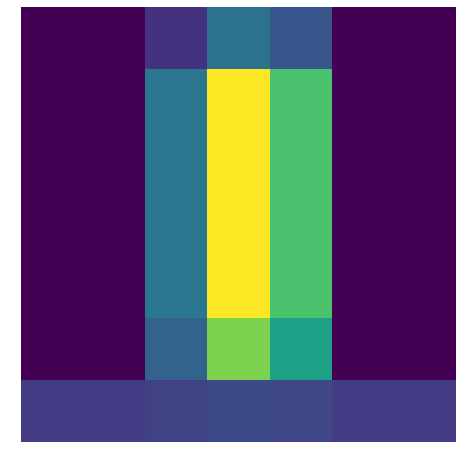

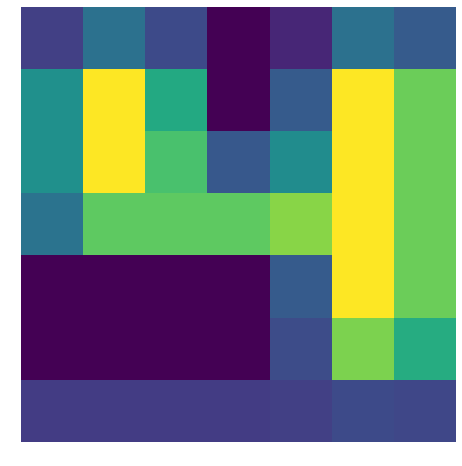

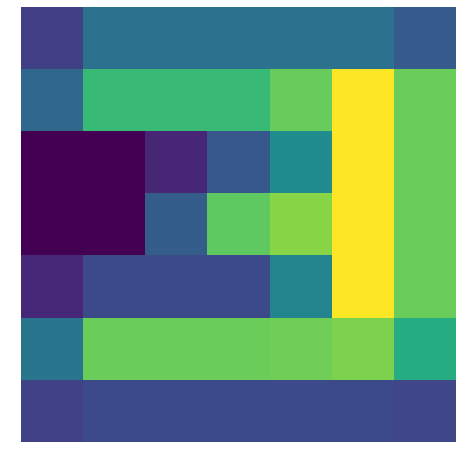

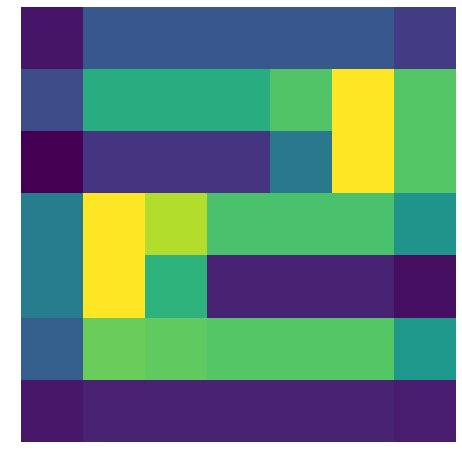

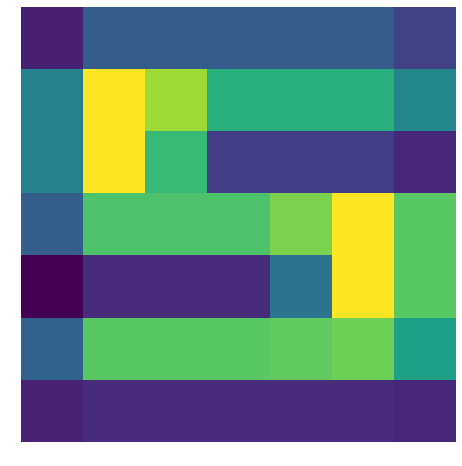

In [4]:
episodes = 1
env = gym.make("Breakout-v0")
init = env.reset()

for i in range(episodes):
    print("Welcome to AI Breakout!")
    print("Starting Test Game...\n")

    
    game = True
    LIVES = []
    while game:
        
        action = env.action_space.sample()
        
        observation, reward, done, info = env.step(action)
        observation, lives = process_obs(observation)
        LIVES.append(lives)
        
        if done:
            
            LIVES = np.unique(np.array(LIVES), axis=0)
            
            for i in LIVES:
                plot_state(i.reshape(7,7))
            game = False
            observation = env.reset()
                             
        else:
            pass
            
         

In [5]:
env = gym.make("Breakout-v0")
init = env.reset()

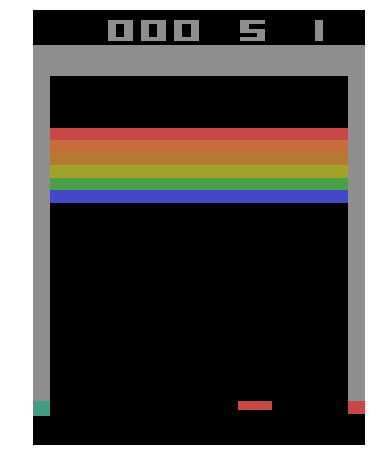

In [6]:
plot_state(init)

In [7]:
init.shape

(210, 160, 3)

In [8]:
I = process_obs(init)[0]

/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


In [9]:
I.shape

(84, 84, 1)

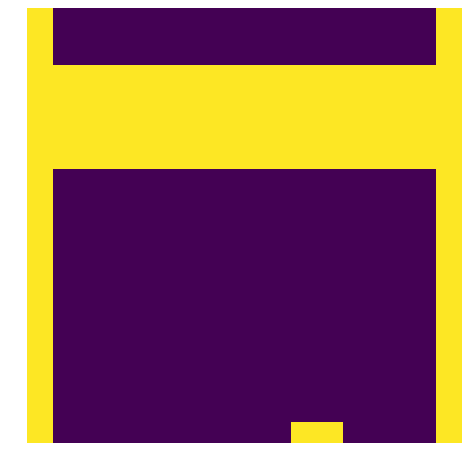

In [10]:
plot_state(I.reshape(84,84))

In [11]:
env.action_space

Discrete(4)

In [12]:
inp = Input(shape=(84,84,4))
x = Conv2D(16, (8,8), strides=4, activation="relu", input_shape=(84,84,4))(inp)
x = Conv2D(32, (4,4), strides=2, activation="relu")(x)
x = Flatten()(x)
x = Dense(256,  activation="relu")(x)
output = Dense(env.action_space.n)(x)

model = Model(inp, output)
callbacks_list = [keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.01, patience=2, mode = min, verbose = 1)]
model.compile(loss='mean_squared_error', optimizer=optimizers.RMSprop(lr=0.00025, rho=0.95, epsilon=0.01), metrics=["mae"])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 16)        4112      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 32)          8224      
_________________________________________________________________
flatten_1 (Flatten)          (None, 2592)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               663808    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 677,172
Trainable params: 677,172
Non-trainable params: 0
_________________________________________________________________
None

/Users/samwilliams/homebrew/lib/python3.7/site-packages/keras/callbacks.py:1086: RuntimeWarning: Learning Rate Plateau Reducing mode <built-in function min> is unknown, fallback to auto mode.
  RuntimeWarning)


In [13]:
LIFE = {}
LIFE["1"] = LIVES[0]
LIFE["2"] = LIVES[3]
LIFE["3"] = LIVES[2]
LIFE["4"] = LIVES[1]
LIFE["5"] = LIVES[4]

In [14]:
for i,j in LIFE.items():
    print(i)

1
2
3
4
5


In [15]:
full_episode_history = {"state" : np.array([]), "reward" : np.array([]), "action": np.array([]), "Q": np.array([])}

In [16]:
env = gym.make("Breakout-v0")
observation = env.reset()
observation, lives = process_obs(observation)

episodes = 1000
episode_scores = []
epsilon = 1.0
gamma = 0.99
done = False

for i in range(1, episodes+1):
    print("Welcome to AI Breakout!")
    print("Starting Game {} of {}...\n".format(i, episodes))
    
    sum = 0
    frame = 1
    game = True
    LIVES = []
    observation_batch = []
    reward_batch = []
    episode_history = {"state" : np.array([]), "reward" : np.array([]), "action": np.array([]), "Q": np.array([])}

    while game: 
        if (frame == 1):
            action = 1              
        else:
            if (frame - 1) % 4 == 0:
                rand = np.random.uniform(0,1)
                if  rand < epsilon:
                    action = env.action_space.sample()
                else:
                    observation = np.expand_dims(episode_history["state"][-1],0)
                    action = np.argmax(model.predict(observation))
                
                if len(episode_history["state"]) > 2:
                    if np.array_equal(episode_history["state"][-1], episode_history["state"][-2]):
                        action = 1
                    else:
                        pass
                else:
                    pass
                observation_batch = []
                reward_batch = []
                
            else:
                pass
            
        
        observation, reward, done, info = env.step(action)
        observation, lives = process_obs(observation)
        
        if len(LIVES) == 0:
            LIVES.append(lives)
            loss = 0
        else:
            if np.array_equal(LIVES[-1], lives):
                loss = 0
            else:
                LIVES.append(lives)
                loss = -10
                
        observation_batch.append(observation)
        reward_batch.append(10*reward+loss)        
        
        if (frame % 4 == 0):
            if frame == 4:
                episode_history["state"] = np.concatenate([i for i in observation_batch], axis=-1)
                episode_history["state"] = np.expand_dims(episode_history["state"],0)

            else:
                obs = np.concatenate([i for i in observation_batch], axis=-1)
                obs = np.expand_dims(obs,0)
                episode_history["state"] = np.concatenate([episode_history["state"], obs], axis=0)

            episode_history["reward"] = np.concatenate([episode_history["reward"], np.array([np.sum(reward_batch)])], axis = 0)  
            episode_history["action"] = np.concatenate([episode_history["action"], np.array([action])], axis=0)
         
        sum += reward
        frame += 1
        if done:

            for j,k in enumerate(episode_history["reward"][::-1]):
                
                if j == 0:
                    val = np.array([[0, 0, 0, 0]], dtype="float32")
                    val[0,int(episode_history["action"][-1])] = k
                    Q = val
                else:
                    val = np.array([[0, 0, 0, 0]], dtype="float32")
                    val[0,int(episode_history["action"][-1-j])] = k + gamma*np.sum(Q[-1])
                    Q = np.concatenate([Q,val], axis = 0)
                    
            Q = Q[::-1]
            episode_history["Q"] = Q
                        
            if i == 1:
                full_episode_history["state"] = episode_history["state"]
                full_episode_history["Q"] = episode_history["Q"]
            else:
                full_episode_history["state"] = np.concatenate([full_episode_history["state"], episode_history["state"]], axis = 0)
                full_episode_history["Q"] = np.concatenate([full_episode_history["Q"], episode_history["Q"]], axis = 0)

            full_episode_history["reward"] = np.concatenate([full_episode_history["reward"], episode_history["reward"]], axis = 0)
            full_episode_history["action"] = np.concatenate([full_episode_history["action"], episode_history["action"]], axis = 0)
            
            
            print("Training the model from a random batch...")
            
            rand = np.random.choice([i for i in range(full_episode_history["action"].shape[0])], size=32)
            inp = full_episode_history["state"][rand]
            target = full_episode_history["Q"][rand]
            model.fit(inp, target, epochs = 5, batch_size=8, verbose=0)
            print("Total game score was: {}".format(int(sum)))
            print("Epsilon: {}\n".format(epsilon))
            
            observation = env.reset()
            observation, lives = process_obs(observation)
            episode_scores.append(int(sum))
            
            m = -9e-7
            epsilon = round(m*full_episode_history["state"].shape[0] +1,3)
            if epsilon < 0.1:
                epsilon = 0.1
            game = False
            frame = 0
 
                             
        else:
            pass
            
         

Welcome to AI Breakout!
Starting Game 1 of 1000...



/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


Training the model from a random batch...
Total game score was: 2
Epsilon: 1.0

Welcome to AI Breakout!
Starting Game 2 of 1000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 1.0

Welcome to AI Breakout!
Starting Game 3 of 1000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 1.0

Welcome to AI Breakout!
Starting Game 4 of 1000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 1.0

Welcome to AI Breakout!
Starting Game 5 of 1000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 1.0

Welcome to AI Breakout!
Starting Game 6 of 1000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 1.0

Welcome to AI Breakout!
Starting Game 7 of 1000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 1.0

Welcome to AI Breakout!
Starting Game 8 of 1000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 1

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.996

Welcome to AI Breakout!
Starting Game 63 of 1000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.996

Welcome to AI Breakout!
Starting Game 64 of 1000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.996

Welcome to AI Breakout!
Starting Game 65 of 1000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.996

Welcome to AI Breakout!
Starting Game 66 of 1000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.996

Welcome to AI Breakout!
Starting Game 67 of 1000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.996

Welcome to AI Breakout!
Starting Game 68 of 1000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.996

Welcome to AI Breakout!
Starting Game 69 of 1000...

Training the model from a random batch...
Total game sc

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.992

Welcome to AI Breakout!
Starting Game 124 of 1000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.992

Welcome to AI Breakout!
Starting Game 125 of 1000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.992

Welcome to AI Breakout!
Starting Game 126 of 1000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.992

Welcome to AI Breakout!
Starting Game 127 of 1000...

Training the model from a random batch...
Total game score was: 5
Epsilon: 0.992

Welcome to AI Breakout!
Starting Game 128 of 1000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.992

Welcome to AI Breakout!
Starting Game 129 of 1000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.992

Welcome to AI Breakout!
Starting Game 130 of 1000...

Training the model from a random batch...
Total 

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.989

Welcome to AI Breakout!
Starting Game 185 of 1000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.989

Welcome to AI Breakout!
Starting Game 186 of 1000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.989

Welcome to AI Breakout!
Starting Game 187 of 1000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.989

Welcome to AI Breakout!
Starting Game 188 of 1000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.989

Welcome to AI Breakout!
Starting Game 189 of 1000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.989

Welcome to AI Breakout!
Starting Game 190 of 1000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.989

Welcome to AI Breakout!
Starting Game 191 of 1000...

Training the model from a random batch...
Total 

Total game score was: 2
Epsilon: 0.985

Welcome to AI Breakout!
Starting Game 245 of 1000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.985

Welcome to AI Breakout!
Starting Game 246 of 1000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.985

Welcome to AI Breakout!
Starting Game 247 of 1000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.985

Welcome to AI Breakout!
Starting Game 248 of 1000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.985

Welcome to AI Breakout!
Starting Game 249 of 1000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.985

Welcome to AI Breakout!
Starting Game 250 of 1000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.985

Welcome to AI Breakout!
Starting Game 251 of 1000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.985

Welcome 

Welcome to AI Breakout!
Starting Game 305 of 1000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.982

Welcome to AI Breakout!
Starting Game 306 of 1000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.981

Welcome to AI Breakout!
Starting Game 307 of 1000...

Training the model from a random batch...
Total game score was: 4
Epsilon: 0.981

Welcome to AI Breakout!
Starting Game 308 of 1000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.981

Welcome to AI Breakout!
Starting Game 309 of 1000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.981

Welcome to AI Breakout!
Starting Game 310 of 1000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.981

Welcome to AI Breakout!
Starting Game 311 of 1000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.981

Welcome to AI Breakout!
Starting Game 312 of 100

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.978

Welcome to AI Breakout!
Starting Game 366 of 1000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.978

Welcome to AI Breakout!
Starting Game 367 of 1000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.978

Welcome to AI Breakout!
Starting Game 368 of 1000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.978

Welcome to AI Breakout!
Starting Game 369 of 1000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.978

Welcome to AI Breakout!
Starting Game 370 of 1000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.978

Welcome to AI Breakout!
Starting Game 371 of 1000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.978

Welcome to AI Breakout!
Starting Game 372 of 1000...

Training the model from a random batch...
Total 

Total game score was: 1
Epsilon: 0.974

Welcome to AI Breakout!
Starting Game 426 of 1000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.974

Welcome to AI Breakout!
Starting Game 427 of 1000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.974

Welcome to AI Breakout!
Starting Game 428 of 1000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.974

Welcome to AI Breakout!
Starting Game 429 of 1000...

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.974

Welcome to AI Breakout!
Starting Game 430 of 1000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.974

Welcome to AI Breakout!
Starting Game 431 of 1000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.974

Welcome to AI Breakout!
Starting Game 432 of 1000...

Training the model from a random batch...
Total game score was: 0
Epsilon: 0.974

Welcome 

Training the model from a random batch...
Total game score was: 1
Epsilon: 0.971

Welcome to AI Breakout!
Starting Game 487 of 1000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.971

Welcome to AI Breakout!
Starting Game 488 of 1000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.971

Welcome to AI Breakout!
Starting Game 489 of 1000...

Training the model from a random batch...
Total game score was: 3
Epsilon: 0.971

Welcome to AI Breakout!
Starting Game 490 of 1000...

Training the model from a random batch...
Total game score was: 2
Epsilon: 0.971

Welcome to AI Breakout!
Starting Game 491 of 1000...

Training the model from a random batch...
Total game score was: 5
Epsilon: 0.97

Welcome to AI Breakout!
Starting Game 492 of 1000...

Training the model from a random batch...
Total game score was: 5
Epsilon: 0.97

Welcome to AI Breakout!
Starting Game 493 of 1000...

Training the model from a random batch...
Total ga

KeyboardInterrupt: 

In [17]:
print(full_episode_history["state"].shape)
print(episode_history["reward"].shape)
print(episode_history["action"].shape)
print(episode_history["Q"].shape)

(36150, 84, 84, 4)
(86,)
(86,)
(86, 4)


In [18]:
print(episode_history["reward"][:])

[  0.   0.   0.   0.   0.   0.   0. -10.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.  10.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0. -10.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 -10.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  10.   0.   0.   0.   0.   0.   0.   0.   0.   0. -10.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.  10.   0.   0.   0.   0.   0.
   0.   0.]


In [19]:
print(episode_history["action"])

[1. 3. 2. 2. 2. 0. 1. 3. 1. 2. 3. 3. 0. 2. 1. 2. 3. 0. 0. 1. 2. 3. 2. 3.
 1. 2. 3. 3. 3. 2. 2. 2. 0. 2. 1. 3. 0. 0. 0. 1. 0. 1. 1. 0. 2. 1. 3. 2.
 1. 0. 0. 3. 3. 2. 3. 2. 3. 2. 2. 1. 3. 2. 1. 3. 0. 3. 3. 3. 1. 3. 0. 3.
 3. 3. 3. 1. 1. 3. 1. 3. 2. 3. 2. 1. 1. 2.]


In [20]:
print(episode_history["Q"][10])

[ 0.          0.          0.         -0.66164166]


In [21]:
model.predict(np.expand_dims(episode_history["state"][50],0))

array([[ 4.1419353, -0.5375553, -2.5964048,  1.7768619]], dtype=float32)

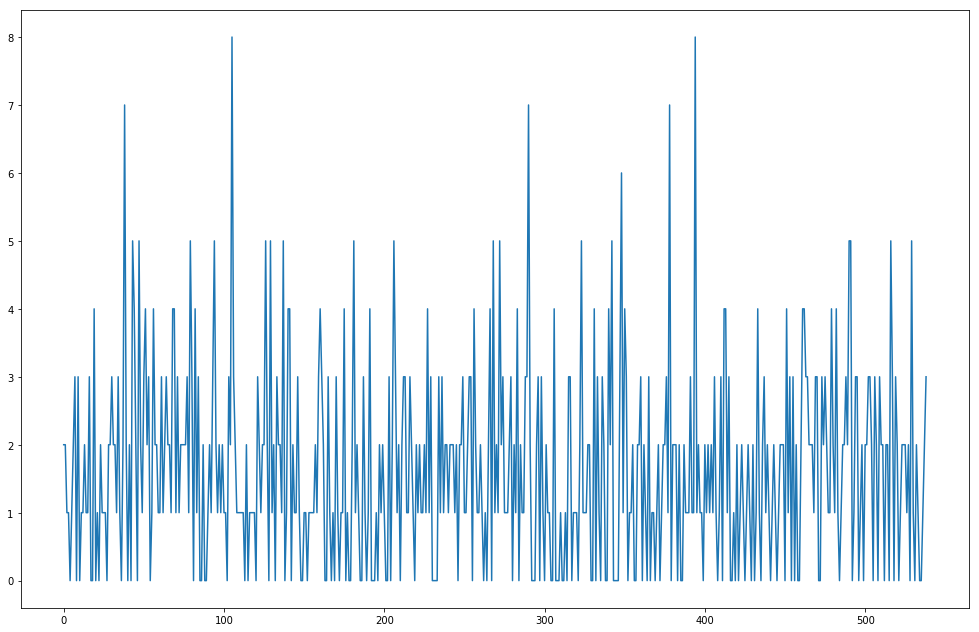

In [22]:
plt.figure(figsize=(17,11))
plt.plot(episode_scores)
plt.show()

# Saving Model

In [23]:
model.save("breakout-atari-rl.h5")

# Testing the Model

In [24]:
mod = load_model("breakout-atari-rl.h5")

In [ ]:

env = gym.make("Breakout-v0")
observation = env.reset()
observation, lives = process_obs(observation)

episodes = 10
done = False
epsilon = 0


for i in range(1, episodes+1):
    print("Welcome to AI Breakout!")
    print("Starting Game {} of {}...".format(i, episodes))
    
    sum = 0
    frame = 1
    game = True
    observation_batch = []
    while game:
        
        if (frame == 1):
            action = 1              
        else:
            if (frame - 1) % 4 == 0:
                action = np.argmax(mod.predict(states)) 

                if np.array_equal(states[0][:84,:84,0], states[0][:84,:84,3]):
                    action = 1
                else:
                    pass
                
                observation_batch = []                
            else:
                pass
            
        
        observation, reward, done, info = env.step(action)
        observation, lives = process_obs(observation)
        observation_batch.append(observation)
        
        if (frame % 4 == 0):
            states = np.concatenate([i for i in observation_batch], axis=-1)
            states = np.expand_dims(states,0)


        sum += reward
        frame += 1
        time.sleep(0.03)
        env.render()

        if done:
            print("Total game score was: {}\n".format(int(sum)))
            observation = env.reset()
            observation, lives = process_obs(observation)
            game = False
env.close()        



/Users/samwilliams/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


Welcome to AI Breakout!
Starting Game 1 of 10...
